In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import math

import pyreadr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
# from keras.utils import plot_model
# import pydot
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.2-arm64-arm-64bit
Tensor Flow Version: 2.18.0
Keras Version: 3.9.0

Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.4.2
GPU is NOT AVAILABLE


In [ ]:
import os
notebook_dir = "/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes"  
os.chdir(notebook_dir)  # Change directory
print(os.getcwd())  


/Users/monamousavi/Dropbox/Causal_climate/My_own_Shared/Takashi_code/Rlearner/Codes


In [3]:
data_2nd_stage = pyreadr.read_r(r'./data_20230504/data_2nd_stage.rds')[None] 
evall_N_seq = pyreadr.read_r(r'./data_20230504/evall_N_seq.rds')[None] 

df_train_sim_id = pd.read_csv('./Output_ann_Train_5field/df_train_sim_id.csv')

In [4]:
sim_id_train = np.array(df_train_sim_id.iloc[1])
sim_id_train = np.delete(sim_id_train,0,0)

sim_id_train[0]

124

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#  Pytorch model 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Each branch processes x (first 3 columns) and multiplies its output by T.
        self.branch1 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch2 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.branch3 = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, inp):
        # inp is of shape (batch_size, 6)
        x = inp[:, :3]         # first three columns (features for the dense layers)
        T = inp[:, 3:]         # last three columns (scaling factors)
        T1 = T[:, 0:1]         # keep as (batch_size, 1)
        T2 = T[:, 1:2]
        T3 = T[:, 2:3]
        
        out1 = self.branch1(x) * T1
        out2 = self.branch2(x) * T2
        out3 = self.branch3(x) * T3
        output = out1 + out2 + out3
        return output

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop over simulation indices
for j in tqdm(range(2)):
    # Get unique simulation ids from  data_2nd_stage 
    sim_ids = np.unique(data_2nd_stage.sim)
    sim_ids_ = np.delete(sim_ids, j, axis=0)
    
    
    sim_id_train = np.array(df_train_sim_id.iloc[1])
    sim_id_train = np.delete(sim_id_train, 0, axis=0)
    
    sim_id_test = sim_ids[j]
    
    
    dataset = data_2nd_stage[(data_2nd_stage['sim'] == sim_id_train[0]) |
                             (data_2nd_stage['sim'] == sim_id_train[1]) |          
                             (data_2nd_stage['sim'] == sim_id_train[2]) |
                             (data_2nd_stage['sim'] == sim_id_train[3]) |
                             (data_2nd_stage['sim'] == sim_id_train[4])].reset_index(drop=True)
    
    
    dataset = dataset[['y_tilde','Nk','plateau','b0','T_1_tilde','T_2_tilde','T_3_tilde']]
    
    
    train_dataset = dataset.sample(frac=0.8, random_state=0)   # Each time we run the code we get the same 80% random sample from the dataset
    val_dataset = dataset.drop(train_dataset.index)
    
    
    train_features = train_dataset.copy()
    val_features = val_dataset.copy()
    train_labels = train_features.pop('y_tilde')
    val_labels = val_features.pop('y_tilde')
    
    # Standardize the features based on training data
    scaler = StandardScaler()
    scaler.fit(train_features)
    scaled_train_features = scaler.transform(train_features)
    scaled_val_features = scaler.transform(val_features)
    
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(scaled_train_features, dtype=torch.float32).to(device)
    y_train = torch.tensor(train_labels.values, dtype=torch.float32).unsqueeze(1).to(device) # add an extra dimension to the tensor using  unsqueeze to match the expected output shape.
    X_val = torch.tensor(scaled_val_features, dtype=torch.float32).to(device)
    y_val = torch.tensor(val_labels.values, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create dataLoader for training data
    train_dataset_tensor = TensorDataset(X_train, y_train) # Combines the feature tensor X_train and label tensor y_train into a single dataset object.
    # Split the dataset into mini-batches of size 512. Randomize the order of the data at every epoch 
    train_loader = DataLoader(train_dataset_tensor, batch_size=512, shuffle=True)
    
    # Initialize the model, loss function and optimizer
    model = MyModel().to(device)
    criterion = nn.L1Loss()  # mean absolute error loss. This loss measures how far off the predictions are.
    optimizer = optim.Adam(model.parameters(), lr=0.001) # how much to update the weights in each iteration.
    
    # Training loop with early stopping
    best_val_loss = np.inf # initializes the best validation loss to infinity. 
    patience = 10 # how many epochs to wait for an improvement in validation loss before stopping training.
    counter = 0 # how many epochs have passed without improvement.
    num_epochs = 500 # the training loop will run for up to 500 epochs unless early stopping triggers.
    
    for epoch in range(num_epochs):
        model.train() # set the model into training mode
        running_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad() # clear any previous gradient calculations.
            outputs = model(batch_X) # compute the model's predictions for the current batch.
            loss = criterion(outputs, batch_y) # calculate how far off the predictions are from the actual labels.
            loss.backward() # compute gradients for each parameter by backpropagation.
            optimizer.step() # adjust the model's parameters based on the gradients.
            running_loss += loss.item() * batch_X.size(0) # The loss for each batch is multiplied by the number 
            # of samples in that batch (batch_X.size(0)) and added to running_loss.
        #  the average loss per sample for an epoch: 
        train_loss = running_loss / len(train_loader.dataset) # divide the total loss by the total number of samples in the dataset:
        
        # Evaluate on validation set
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # not to compute gradients during the forward pass.
            val_outputs = model(X_val) # model predictions for val
            val_loss = criterion(val_outputs, y_val).item() # convert loss tensor into a standard python float.
        
        # Early stopping check
        if val_loss < best_val_loss: 
            best_val_loss = val_loss
            counter = 0 # model improved
        else:
            counter += 1 # how many consecutive epochs have passed without improvement.
        
        if counter >= patience: #  if the validation loss does not improve for 10 consecutive epochs, the training loop will stop early.
            print(f"Early stopping at epoch {epoch} for sim_id {sim_id_test}")
            break
        
        # Optional: print training progress
        # print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
    
    # Predict on validation set
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).cpu().numpy().flatten()
    
    outcome_val = pd.DataFrame({'pred': val_preds, 'true': val_labels.values})
    outcome_val.to_csv('./Pytorch_outcome/validation_{}.csv'.format(sim_id_test), index=False)
    
    ## EONR estimation
    p_corn = 6.25 / 25.4  
    p_N = 1 / 0.453592   
    
    # select test dataset for the current simulation
    test_dataset = data_2nd_stage[data_2nd_stage['sim'] == sim_id_test]
    features = test_dataset[['Nk','plateau','b0']]
    
    test_evall_N_seq = evall_N_seq[evall_N_seq['sim'] == sim_id_test].reset_index(drop=True)
    Nseq = test_evall_N_seq['N'].values
    n_row = test_dataset.shape[0]
    
    estEONR_vector = []
    
    # Loop over each row in the test dataset to estimate EONR
    for i in range(n_row):
        feature_1 = features.iloc[i, :]
        rep_feature_1 = pd.concat([feature_1]*100, axis=1).T
        rep_feature_1.reset_index(drop=True, inplace=True)
        rep_feature_1 = pd.concat([rep_feature_1, test_evall_N_seq.iloc[:, 0:3]], axis=1)
        rep_feature_1.rename(columns={'T_1':'T_1_tilde', 'T_2':'T_2_tilde', 'T_3':'T_3_tilde'}, inplace=True)
        
        # Scale the features using the previously fitted scaler
        scaled_feature_1 = scaler.transform(rep_feature_1)
        X_feature = torch.tensor(scaled_feature_1, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            prediction = model(X_feature).cpu().numpy().reshape(-1)
        
        MP = prediction * p_corn - Nseq * p_N
        estEONR = Nseq[np.argmax(MP)]
        estEONR_vector.append(estEONR)
        
    outcome = pd.DataFrame({'pred': estEONR_vector, 'true': test_dataset['opt_N'].values})
    outcome.to_csv('./Pytorch_outcome/EONR_{}.csv'.format(sim_id_test), index=False)
    
    
    # df_train_sim_id = pd.concat([df_train_sim_id, pd.DataFrame(sim_id_train).T])
    
# reset index and save df_train_sim_id
# df_train_sim_id.reset_index(inplace=True)
# df_train_sim_id.to_csv('./Output_Rann/df_train_sim_id.csv', index=False)


  0%|          | 0/2 [00:00<?, ?it/s]

Early stopping at epoch 122 for sim_id 1


 50%|█████     | 1/2 [00:06<00:06,  6.74s/it]

Early stopping at epoch 120 for sim_id 2


100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


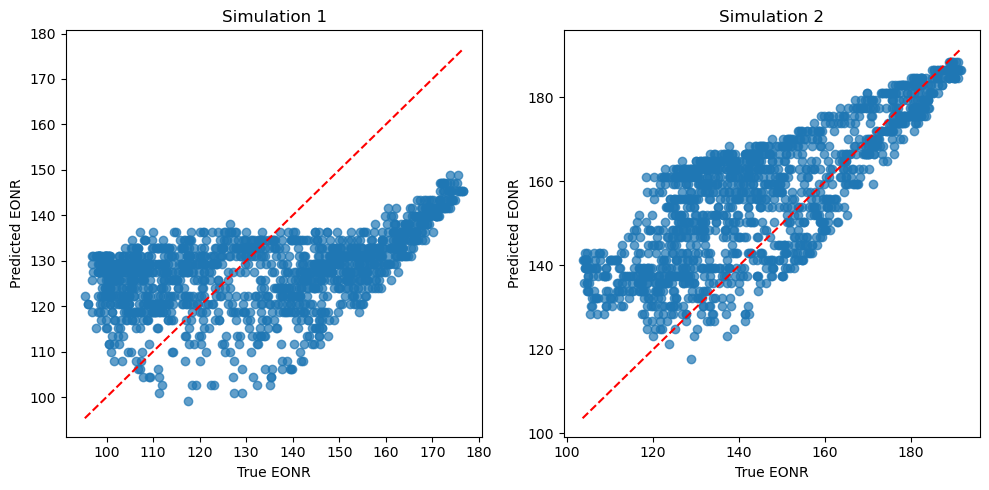

In [ ]:
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt

# all EONR CSV files
file_list = glob.glob('./Pytorch_outcome/EONR_*.csv')
num_files = len(file_list)

# grid layout
cols = 2
rows = math.ceil(num_files / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)

for idx, file in enumerate(file_list):
    # Read CSV without index_col so pred and true become columns
    df = pd.read_csv(file)  

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    
    # plot of true vs predicted EONR
    ax.scatter(df['true'], df['pred'], alpha=0.7)
    ax.set_xlabel('True EONR')
    ax.set_ylabel('Predicted EONR')
    
    # get simulation id from filename
    sim_id = file.split('_')[-1].replace('.csv', '')
    ax.set_title(f"Simulation {sim_id}")
    
    # Plot y = x 
    min_val = min(df['true'].min(), df['pred'].min())
    max_val = max(df['true'].max(), df['pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

# If we have more subplots than files, remove unused axes
for idx in range(num_files, rows*cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()
